In [12]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def select_action(self, s):
        action_prob = self.forward(s)
        action = action_prob.detach().numpy()*(max) # bound the actions to the valid range
        return action
    


class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, s, a):
        x = torch.cat([s, a], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Agent(object):
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

        s_dim = self.env.observation_space.shape[0]
        a_dim = self.env.action_space.shape[0]

        self.actor = Actor(s_dim, 64, a_dim)
        self.actor_t = Actor(s_dim, 64, a_dim)
        self.actor_target = Actor(s_dim, 64, a_dim)

        self.actor_temp_target = Actor(s_dim, 64, a_dim)

        self.critic = Critic(s_dim+a_dim, 64, a_dim)
        self.critic_t = Critic(s_dim+a_dim, 64, a_dim)
        self.critic_target = Critic(s_dim+a_dim, 64, a_dim)

        self.actor_optim = optim.Adam(self.actor.parameters(), lr = self.actor_lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
        
        
        self.actor_optim_t = optim.Adam(self.actor_t.parameters(), lr = self.actor_lr)
        self.critic_optim_t = optim.Adam(self.critic_t.parameters(), lr = self.critic_lr)

        self.buffer = []
        self.tempbuffer=[]
        self.D0=[]
        self.D1=[]
        self.a_prob=[]
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
    def act(self,actor,s0):
        s0 = torch.tensor(s0, dtype=torch.float).unsqueeze(0)
        a_prob = ((actor(s0).detach().numpy()+1)*(0.5)).squeeze(0)
        a0 = actor.select_action(s0).squeeze(0)
        return a0,a_prob
    
    def put(self, *transition): 
        if len(self.buffer)== self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)
    
    def put_d0(self, *transition):
        self.D0.append(transition)
    
    def put_d1(self, *transition):
        self.D1.append(transition)
    
    def gen_D(self, actor, Step, Dtype):
        s0 = env.reset()
        episode_reward = 0
        returns=[]
        for step in range(Step):
            a0 ,a_prob= self.act(actor,s0)
            s1, r1, done, _ = env.step(a0)
            self.put(s0, a0, r1, s1, a_prob)
            if Dtype==0:
              self.a_prob.append(a_prob)
              self.put_d0(s0, a0, r1, s1, a_prob)
            elif Dtype==1:
              self.put_d1(s0, a0, r1, s1, a_prob)
            episode_reward += r1 
            s0 = s1
            returns.append(r1)
       
       
        return returns
    def test(self, actor, Step):
        s0 = env.reset()
        episode_reward = 0
        returns=[]
        for step in range(Step):
            a0 ,a_prob= self.act(actor,s0)
            s1, r1, done, _ = env.step(a0)
            episode_reward += r1 
            s0 = s1
            returns.append(r1)
        return returns
            

    def ddpg_temp(self):
        actor_temp = copy.deepcopy(self.actor_target)
        critic_temp = copy.deepcopy(self.critic_target)
        self.actor_temp_target = copy.deepcopy(self.actor_target)
        critic_temp_target = copy.deepcopy(self.critic_target)
        critic_optim_temp = optim.Adam(critic_temp.parameters(), lr = self.critic_lr)
        actor_optim_temp = optim.Adam(actor_temp.parameters(), lr = self.actor_lr)


        if len(self.D0) < self.batch_size:
            return 
        samples = random.sample( self.D0, self.batch_size)
        s0, a0, r1, s1, a_prob = zip(*samples)
        
        s0 = torch.tensor(s0, dtype=torch.float)
        a0 = torch.tensor(a0, dtype=torch.float)
        r1 = torch.tensor(r1, dtype=torch.float).view(self.batch_size,-1)
        s1 = torch.tensor(s1, dtype=torch.float)
        a_prob = torch.tensor(a_prob, dtype=torch.float)
        
        def critic_learn():
            a1 = torch.tensor(self.actor_temp_target.select_action(s1))
            y_true = r1 + self.gamma * critic_temp_target(s1, a1).detach()

            y_pred = critic_temp(s0, a0)

            loss_fn = nn.MSELoss()
            loss = loss_fn(y_pred, y_true)
            critic_optim_temp.zero_grad()
            loss.backward()
            critic_optim_temp.step()
            
        def actor_learn():
            loss = -torch.mean( critic_temp( s0, actor_temp(s0)) )
            actor_optim_temp.zero_grad()
            loss.backward()
            actor_optim_temp.step()
                                           
        def soft_update(net_target, net, tau):
            for target_param, param  in zip(net_target.parameters(), net.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        critic_learn()
        actor_learn()
        soft_update(critic_temp_target, critic_temp, self.tau)
        soft_update(self.actor_temp_target, actor_temp, self.tau)

    
    def update_teacher(self,R_pip,R_pi):
        def actor_learn():
            r_pip=[]
            R1=0
            for r in R_pip[::-1]:
                R1 = r + self.gamma * R1
                r_pip.insert(0, R1)

            r_pi=[]
            R0=0
            for r in R_pi[::-1]:
                R0 = r + self.gamma * R0
                r_pi.insert(0, R0)

            
            loss=0
            
            for prob, r1, r0 in zip(torch.tensor(self.a_prob), r_pip, r_pi):
              loss = loss+((-1) * torch.log(prob) * (r1 - r0))
            loss =  torch.tensor(loss)
            loss=loss.requires_grad_()
            self.actor_optim_t.zero_grad()
            loss.backward()
            self.actor_optim_t.step()
            self.a_prob.clear()
            loss =  torch.tensor(loss)
            self.a_prob.clear()
            loss=loss.requires_grad_()
            self.actor_optim_t.zero_grad()
            loss.backward()
            self.actor_optim_t.step()
        actor_learn()
        self.D0.clear()
        self.D1.clear()

    def ddpg(self):
        if len(self.buffer) < self.batch_size:
              return 
        samples = random.sample(self.buffer, self.batch_size)
        
        s0, a0, r1, s1, a_prob= zip(*samples)
        
        s0 = torch.tensor(s0, dtype=torch.float)
        a0 = torch.tensor(a0, dtype=torch.float)
        r1 = torch.tensor(r1, dtype=torch.float).view(self.batch_size,-1)
        s1 = torch.tensor(s1, dtype=torch.float)
        a_prob = torch.tensor(a_prob, dtype=torch.float)
        
        def critic_learn():
            a1 = torch.tensor(self.actor_target.select_action(s1))
            y_true = r1 + self.gamma * self.critic_target(s1, a1).detach()
            
            y_pred = self.critic(s0, a0)
            
            loss_fn = nn.MSELoss()
            loss = loss_fn(y_pred, y_true)
            self.critic_optim.zero_grad()
            loss.backward()
            self.critic_optim.step()
            
        def actor_learn():
            loss = -torch.mean( self.critic(s0, self.actor(s0)) )
            self.actor_optim.zero_grad()
            loss.backward()
            self.actor_optim.step()
                                           
        def soft_update(net_target, net, tau):
            for target_param, param  in zip(net_target.parameters(), net.parameters()):
                target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
        critic_learn()
        actor_learn()
        soft_update(self.critic_target, self.critic, self.tau)
        soft_update(self.actor_target, self.actor, self.tau)

env = gym.make('Pendulum-v0')
env.reset()
#env.render()
max=env.action_space.high[0]
params = {
    'env': env,
    'gamma': 0.99, 
    'actor_lr': 0.001, 
    'critic_lr': 0.001,
    'tau': 0.02,
    'capacity': 10000, 
    'batch_size': 32,
    }

ep=[]
acu_reward=[]
average_reward = []
timestep = 0

""" Initialize the model """
agent = Agent(**params)

""" Draw D1 , get R_pi and initialize the replay buffer"""
R_pi = agent.gen_D(agent.actor_target, 100, 1)

for episode in range(20000):
    R = agent.gen_D(agent.actor_t,100,0)
    agent.ddpg_temp()
    R_pip = agent.gen_D(agent.actor_temp_target,100,1)
    agent.update_teacher(R_pip,R_pi)
    agent.ddpg()
    R_pi=R_pip
    
    R=agent.test(agent.actor_target,100)
    print(episode, ': ', sum(R))
    ep.append(episode)
    acu_reward.append(sum(R))
    average_reward.append(np.mean(acu_reward[-300:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


串流輸出內容已截斷至最後 5000 行。
15000 :  -115.00347964680988
15001 :  -316.7291424908822
15002 :  -117.95433087444545
15003 :  -0.7342143426349163
15004 :  -1.8725627927308588
15005 :  -119.17116910198706
15006 :  -120.62275186067494
15007 :  -225.65439194939503
15008 :  -119.44485419605614
15009 :  -220.4932435343462
15010 :  -117.37816252643015
15011 :  -1.689182631009509
15012 :  -119.0773781703082
15013 :  -118.7399621011222
15014 :  -116.54775289768686
15015 :  -124.06115244735894
15016 :  -117.18309743557334
15017 :  -118.97209681918793
15018 :  -118.6577613339735
15019 :  -120.20963504388462
15020 :  -225.5868116789498
15021 :  -117.37754137327663
15022 :  -123.07571518388494
15023 :  -117.24533671613646
15024 :  -240.67663681522504
15025 :  -122.09986340587248
15026 :  -121.53686527758846
15027 :  -1.1736499553230515
15028 :  -2.815557442460714
15029 :  -252.15736774173212
15030 :  -0.8685361812789624
15031 :  -1.1980177282015874
15032 :  -223.0543132357527
15033 :  -312.2848330263468
150

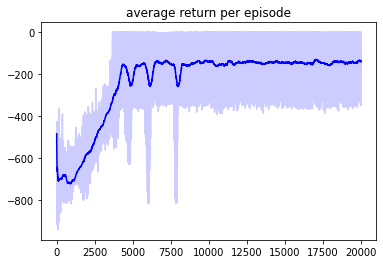

In [13]:
plt.title('average return per episode'.format(episode))
plt.plot(average_reward, color='blue')
plt.plot(acu_reward, color='blue', alpha=0.2)
plt.show()